In [40]:
import measurement_utile

data_storage = measurement_utile.SampleBucket("data/NANDs_Falling")
data_storage.load_sample_index()
samples_list = data_storage.query_samples()


In [41]:
edges = [[], [], []]

for sample_name in samples_list:
    voltage_trace = data_storage.query_sample(sample_name)

    trigger_edge = measurement_utile.detect_edges(measurement_utile.extrat_binary(voltage_trace[1], HIGH_LEVEL=3.5), voltage_trace[0], edge="rf")[-1]

    edges[0].append(measurement_utile.detect_edges(measurement_utile.extrat_binary(voltage_trace[2], HIGH_LEVEL=3.5), voltage_trace[0], edge="rf")[-1] - trigger_edge)
    edges[1].append(measurement_utile.detect_edges(measurement_utile.extrat_binary(voltage_trace[3], HIGH_LEVEL=3.5), voltage_trace[0], edge="rf")[-1] - trigger_edge)
    edges[2].append(measurement_utile.detect_edges(measurement_utile.extrat_binary(voltage_trace[4], HIGH_LEVEL=3.5), voltage_trace[0], edge="rf")[-1] - trigger_edge)


with open(data_storage.path + "/IC_info.json", "r") as f:
    CHANNEL_MAPPING = measurement_utile.json.loads(f.read())["Channel_mapping"]



IC-Name   : Max      : Min      : Average
CD4093BE  : 62.00 n  : 53.00 n  : 57.93 n  
U74HC00   : 14.00 n  :  6.00 n  : 11.03 n  
SN74HCT00 : 15.00 n  :  8.00 n  : 12.40 n  


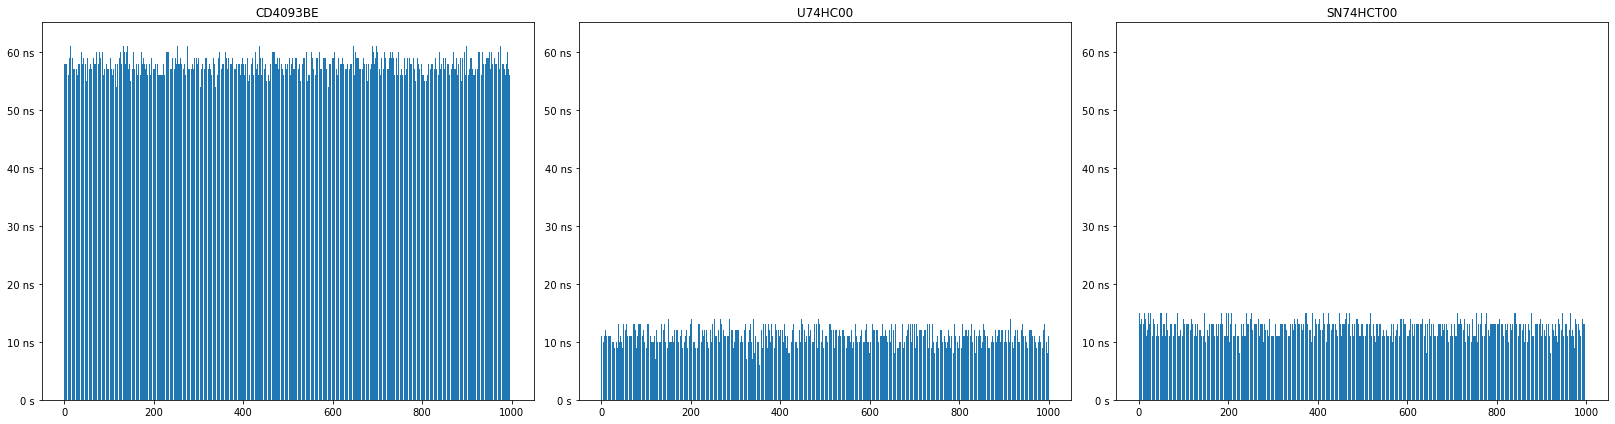

In [42]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.subplots(figsize=(30, 6))

last_ax = None

print("IC-Name   : Max      : Min      : Average")

for i in range(3):
    plt.subplot(1, 4, i+1)
    plt.title(CHANNEL_MAPPING[i])
    ax = plt.gca()
    fig = plt.gcf()
    fig.tight_layout()
    ax.yaxis.set_major_formatter(measurement_utile.formatter_time)
    if last_ax:
        ax.sharey(last_ax)
    plt.bar([i for i in range(len(edges[i]))], edges[i])
    last_ax = ax

    print(CHANNEL_MAPPING[i].ljust(10) + ": " + 
        measurement_utile.format_metric_units(max(edges[i])).ljust(9) + ": " +
        measurement_utile.format_metric_units(min(edges[i])).ljust(9) + ": " +
        measurement_utile.format_metric_units(sum(edges[i])/len(edges[i])).ljust(9))

plt.show()

In [12]:
import matplotlib.pyplot as plt
import measurement_utile

from typing import List, Tuple
import os

def analyse_pd(dataset_file_name, trigger_channel=1, edge="rf") -> Tuple[List[float], List[str]]:
    storage = measurement_utile.SampleBucket(dataset_file_name)
    storage.load_sample_index()
    samples_list = storage.query_samples()

    number_of_channels = len(storage.query_sample(samples_list[0])) - 1
    edges = [[] for i in range(number_of_channels)]

    for sample_name in samples_list:
        voltage_trace = storage.query_sample(sample_name)

        trigger_edge = measurement_utile.detect_edges(measurement_utile.extrat_binary(voltage_trace[trigger_channel], HIGH_LEVEL=3.5), voltage_trace[0], edge=edge)[-1]

        for i in range(1, number_of_channels+1):
            if i == trigger_channel:
                continue
            edges[i-1].append(measurement_utile.detect_edges(measurement_utile.extrat_binary(voltage_trace[i], HIGH_LEVEL=3.5), voltage_trace[0], edge=edge)[-1] - trigger_edge)
    
    if os.path.exists(storage.path + "/IC_info.json"):
        with open(storage.path + "/IC_info.json", "r") as f:
            channel_mapping = measurement_utile.json.loads(f.read())["Channel_mapping"]
    else:
        channel_mapping = ["Channel #{}".format(i+1) for i in range(number_of_channels)]

    return edges, channel_mapping

    plt.show()



In [21]:
def plot_analyse_pd(edges, mapping):
    %matplotlib inline
    plt.subplots(figsize=(30, 6))

    number_of_edges = len(edges)
    number_of_subplots = sum([1 if len(i) > 0 else 0 for i in edges])
    subplot_iteration = 1
    last_ax = None

    print("IC-Name   : Max      : Min      : Average")

    for i in range(number_of_edges):
        if len(edges[i]) <= 0:
            continue

        plt.subplot(1, number_of_subplots, subplot_iteration)
        subplot_iteration += 1
        plt.title(mapping[i])
        ax = plt.gca()
        fig = plt.gcf()
        fig.tight_layout()
        ax.yaxis.set_major_formatter(measurement_utile.formatter_time)
        if last_ax:
            ax.sharey(last_ax)
        plt.bar([i for i in range(len(edges[i]))], edges[i])
        last_ax = ax

        print(mapping[i].ljust(10) + ": " + 
            (measurement_utile.format_metric_units(max(edges[i])) + "s").ljust(9) + ": " +
            (measurement_utile.format_metric_units(min(edges[i])) + "s").ljust(9) + ": " +
            (measurement_utile.format_metric_units(sum(edges[i])/len(edges[i])) + "s").ljust(9))


IC-Name   : Max      : Min      : Average
74HC573_R : 15.60 ns : 11.80 ns : 13.70 ns 
74HC541_R : 14.80 ns : 11.40 ns : 12.96 ns 
74HC573_F : 12.40 ns :  8.00 ns : 10.10 ns 
74HC541_F : 14.00 ns :  9.20 ns : 11.59 ns 


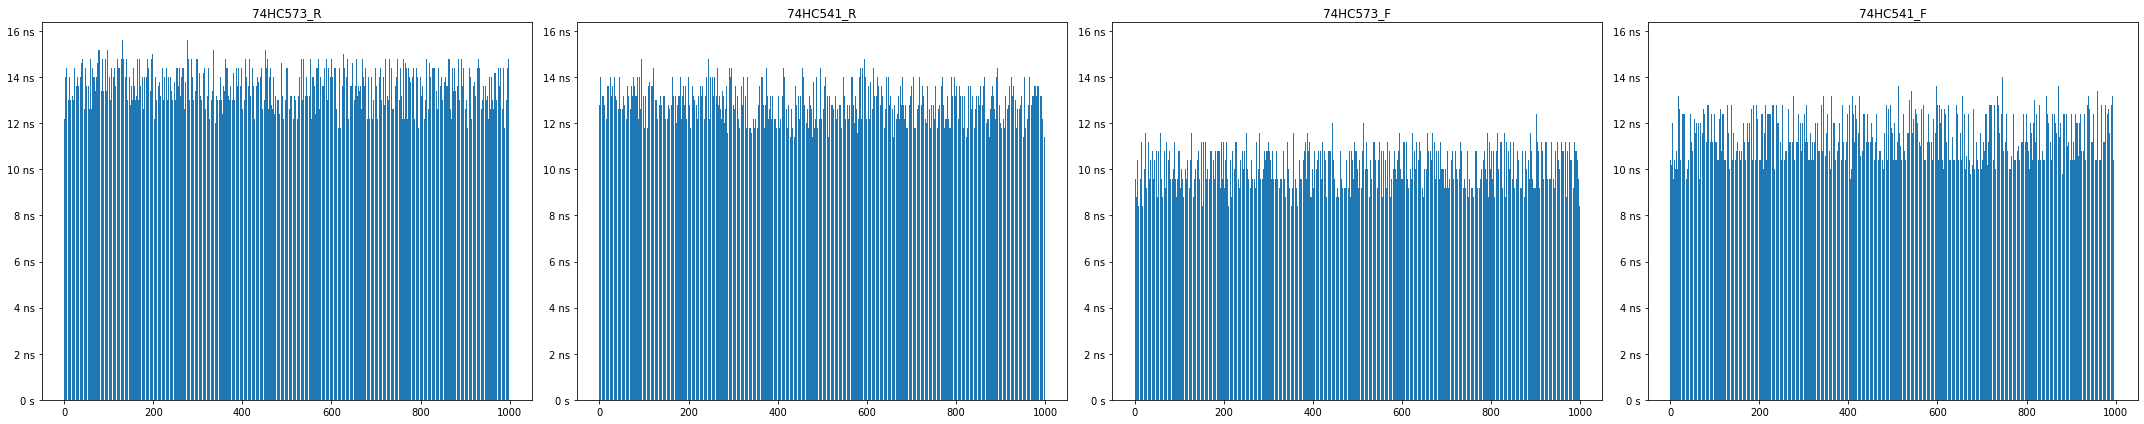

In [23]:
edges_r, mapping_r = analyse_pd("data/Buffer_Response_Rising")
edges_f, mapping_f = analyse_pd("data/Buffer_Response_Falling")
plot_analyse_pd(edges_r + edges_f, mapping_r + mapping_f)